In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [4]:
import igraph as ig

In [5]:
F=ig.Graph.Read("../graphs/ncol/facebook_combined.txt",format="ncol").as_undirected()

In [6]:
def findCommunities(graph):
    partition=graph.community_multilevel()
    for idx, c in enumerate(partition):
        color=[random(),random(),random(),1.]
        for v in c:
            partition.graph.vs[v]["color"]=color
            partition.graph.vs[v]["cluster"]=idx
            for e in partition.graph.incident(v):
                ed=partition.graph.es[e]
                if ed.source in c and ed.target in c:
                    ed["color"]=[0.,0.,0.,1.]
                else:
                    ed["color"]=[0.5,0.5,0.5,1.]
    return partition

In [7]:
def chooseVertex(graph):
    assert len(graph.vs)>0, "Can't choose a vertex in an empty graph." 
    node=None
    minBetweenness = -1
    for idx, betweenness in enumerate(graph.betweenness()):
        if betweenness < minBetweenness or minBetweenness == -1 :
            node= idx
    assert node is not None
    return node

In [8]:
def maxMinPCCNodeSelection(dictPCC):
    assert dictPCC!={}
    chosenId=None
    nbNodes=len(list(dictPCC.values())[0])
    maxDist=-1
    maxSumDist=-1
    maxDistNode=None
    for nodeId in range(nbNodes):
        if nodeId not in dictPCC.keys():
            minDist=-1
            minDistNode=nodeId
            for chosenNode in dictPCC.keys():
                if minDist==-1 or dictPCC[chosenNode][nodeId]<minDist:
                    minDist=dictPCC[chosenNode][nodeId]
            #if equivalent on criterion 1, calculate criterion 2
            sumDist=-1
            if maxSumDist==-1 or minDist==maxDist:
                sumDist=sum([dictPCC[chosenNode][nodeId] for chosenNode in dictPCC.keys()])
            #if better crit1 or equal crit1 but better crit2
            if minDist>maxDist or (minDist==maxDist and sumDist>maxSumDist):
                maxDist=minDist
                maxDistNode=minDistNode
                maxSumDist=sumDist
    chosenId=maxDistNode
    return chosenId

In [9]:
def maxShortestPathNodesSelection(graph,nbNodes,boundaryNodes=[]):
    assert len(graph.vs)-len(boundaryNodes)>= nbNodes, "{} {} {}".format(len(graph.vs),nbNodes,len(boundaryNodes))
    if boundaryNodes==[]:
        chosenIds=[chooseVertex(graph)]
    else:
        chosenIds=boundaryNodes.copy()
    #BFS initial des noeuds dans chosenIds
    matPCC=graph.shortest_paths_dijkstra(chosenIds)
    dictPCC={chosenId:matPCC[idxPCC] for idxPCC,chosenId in enumerate(chosenIds)}
    
    #nbNodes fois
    while len(chosenIds)-len(boundaryNodes)<nbNodes:
        #print(".")
        chosenNodeId=maxMinPCCNodeSelection(dictPCC)

        #BFS du nouveau noeud
        dictPCC[chosenNodeId]=graph.shortest_paths_dijkstra(chosenNodeId)[0] #On prend la ligne de la matrice qui correspond au noeud
        chosenIds.append(chosenNodeId)
    assert len(chosenIds)==len(boundaryNodes)+nbNodes
    return chosenIds[len(boundaryNodes):]

In [10]:
def assignWorkersInCommunity(graph,clusterGraph,clusterId):
    clusterVertices=[v for v in graph.vs if v["cluster"]==clusterId]
    
    boundaryVertices=set()
    for v in clusterVertices: #Trouver les successeurs hors cluster aka les noeuds frontaliers au cluster
        boundaryVertices.update([bv for bv in v.successors() if bv["cluster"]!=clusterId])
    boundaryVertices=list(boundaryVertices)
    
    boundedCluster=graph.induced_subgraph(boundaryVertices+clusterVertices)
    
    #Réidentification des noeuds du graphe global vers le sous-graphe
    boundaryVerticesNames=[v["name"] for v in boundaryVertices]
    boundaryVertices=[v.index for v in boundedCluster.vs if v["name"] in boundaryVerticesNames]

    workerIds=maxShortestPathNodesSelection(boundedCluster,clusterGraph.vs[clusterId]["nb_workers"],boundaryVertices)
    
    #for node in boundedCluster.vs:
    #    if node["name"]in boundedCluster.vs[workerIds]["name"]:
    #        node["shape"]="triangle"

    #ig.plot(boundedCluster,"../graphs/img/cluster{}.png".format(clusterId))
    
    return boundedCluster.vs[workerIds]["name"]

In [11]:
def sizeOrderedRoundRobinWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    sortedIdxPerSize=sorted(range(len(relativeSizes)), key=lambda k: relativeSizes[k], reverse=True)
    sortedSizes=sorted(relativeSizes)

    #Round Robin par ordre de taille des clusters
    currentCluster=0
    while remainingWorkers>0:
        currentSortedCluster=sortedIdxPerSize[currentCluster]
        if clusterGraph.vs[currentSortedCluster]["nb_workers"]<len(partition.subgraph(currentSortedCluster).vs):
            clusterGraph.vs[currentSortedCluster]["nb_workers"]+=1
            remainingWorkers-=1
        currentCluster+=1
        if currentCluster>=len(clusterGraph.vs):
            currentCluster=0
    return clusterGraph

In [12]:
def sizeProRataWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    proRataWorkers=[remainingWorkers*size for size in relativeSizes]
    intProRataWorkers=[int(prw) for prw in proRataWorkers]
    
    assignedWorkers=sum(intProRataWorkers)
    if assignedWorkers < remainingWorkers:
        remainingProRataWorkers=[prw - prw//1 for prw in proRataWorkers]
        sortedIdx=sorted(range(len(remainingProRataWorkers)), key=lambda k: remainingProRataWorkers[k], reverse=True)
        print(remainingProRataWorkers)
        print(sortedIdx)
        for i in range(remainingWorkers-assignedWorkers):
            intProRataWorkers[sortedIdx[i]]+=1
            assignedWorkers+=1
        
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=intProRataWorkers[idx]
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return clusterGraph

In [13]:
def assignWorkers(graph,nWorkers):
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(graph.vs))
    partition=findCommunities(graph)
    
    clusterGraph=partition.cluster_graph("first")

    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)

    workerIds=[]
    clusterIds=[]
    if len(partition)<nWorkers:
        #Chaque cluster aura au moins un worker en lui
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        
        #Attribuer le nombre de workers réel
        remainingWorkers=nWorkers-len(clusterGraph.vs)
        
        %time clusterGraph=sizeProRataWorkerAssignement(graph, partition,clusterGraph, remainingWorkers)
        #%time clusterGraph=sizeOrderedRoundRobinWorkerAssignement(graph, partition,clusterGraph, remainingWorkers)
        #clusterGraph=subPartitioning(graph,partition,clusterGraph,remainingWorkers)
        clusterIds=range(len(partition))
        
    elif len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        clusterIds=range(len(partition))
    else:
        clusterIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
        for cluster in clusterGraph.vs:
            if cluster.index in clusterIds:
                cluster["nb_workers"]=1
            else:
                cluster["nb_workers"]=0

    #Etape2
    #for chaque cluster de workers
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    for clusterId in clusterIds:
        %time workerIds.extend(assignWorkersInCommunity(graph,clusterGraph,clusterId))
    
    assert len(workerIds)==nWorkers, "Assigned {} workers instead of {}".format(len(workerIds),nWorkers)
    return workerIds,partition,clusterIds

In [14]:
%time workerIds,partition,clusterIds=assignWorkers(F,100)
print(workerIds)

[0.2790294627383023, 0.9636048526863075, 0.04679376083188913, 0.7972270363951477, 0.29289428076256563, 0.7175043327556327, 0.5164644714038129, 0.3968804159445405, 0.5181975736568458, 0.9289428076256501, 0.5199306759098787, 0.24783362218370897, 0.2842287694973997, 0.7001733102253027, 0.39514731369150774, 0.39514731369150774]
[1, 9, 3, 5, 13, 10, 8, 6, 7, 14, 15, 4, 12, 0, 11, 2]
CPU times: user 13.2 ms, sys: 211 µs, total: 13.4 ms
Wall time: 13.2 ms
CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 18.6 ms
CPU times: user 404 ms, sys: 8.56 ms, total: 413 ms
Wall time: 412 ms
CPU times: user 809 ms, sys: 0 ns, total: 809 ms
Wall time: 808 ms
CPU times: user 498 ms, sys: 0 ns, total: 498 ms
Wall time: 497 ms
CPU times: user 560 ms, sys: 0 ns, total: 560 ms
Wall time: 559 ms
CPU times: user 186 ms, sys: 0 ns, total: 186 ms
Wall time: 185 ms
CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18.5 ms
CPU times: user 84.4 ms, sys: 0 ns, total: 84.4 ms
Wall time: 83.6 ms

## Plot

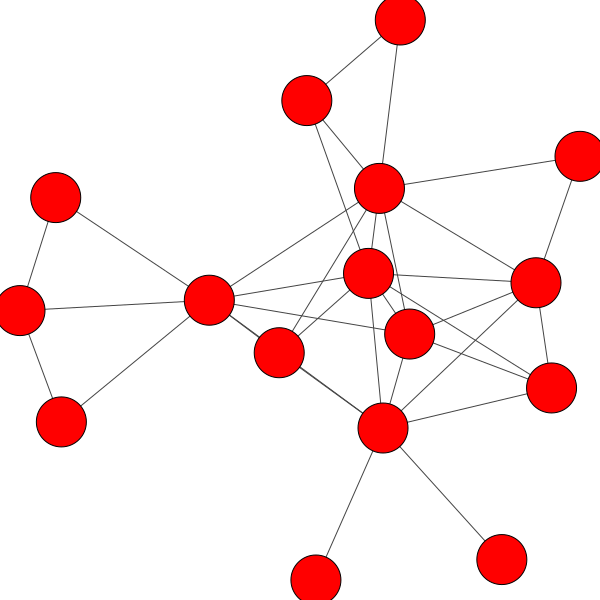

In [15]:
clusterGraph=partition.cluster_graph()
for cluster in clusterGraph.vs:
    if cluster.index in clusterIds:
        cluster["size"]=50
ig.plot(clusterGraph)

In [16]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

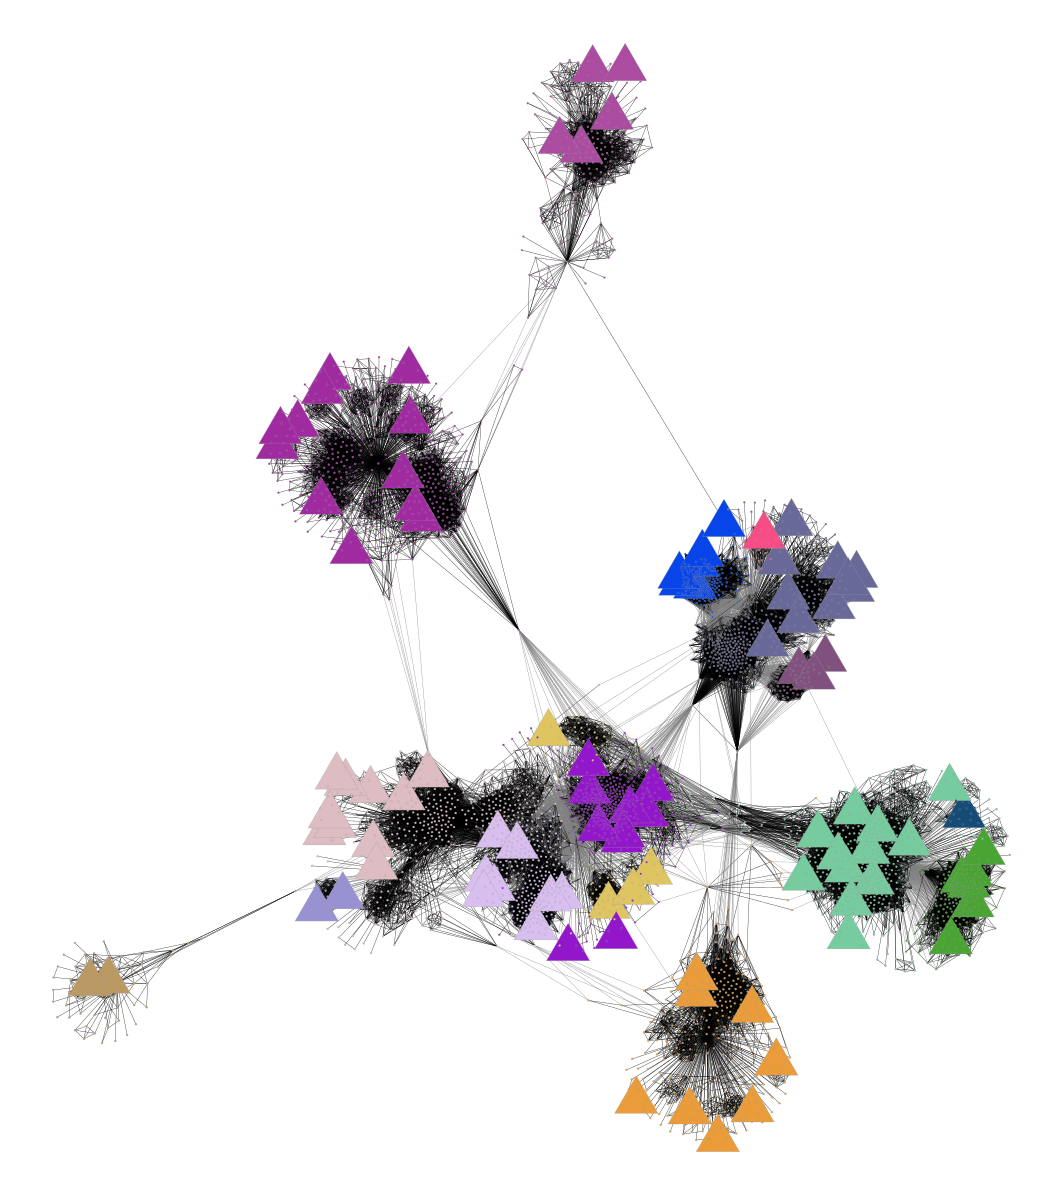

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2fd5cc77f0, at 0x7f2fd0d68be0>

In [17]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

In [18]:
#Given a list of nodes, give distances between nodes
def calcDistBtwnNodes(graph,chosenNodeNames):
    return graph.shortest_paths_dijkstra(source=chosenNodeNames, target=chosenNodeNames)

In [19]:
matPCC=calcDistBtwnNodes(F,workerIds)
PCCList=[]
for sublist in matPCC:
    PCCList.extend(sublist)
maxDist=max(PCCList)
PCCSelf=[]
PCCSameCluster=[]
PCCOtherCluster=[]
for i, sublist in enumerate(matPCC):
    source=F.vs.find(workerIds[i])
    for j in sublist:
        target=F.vs.find(workerIds[j])
        #print(source,target)
        if source["name"]==target["name"]:
            PCCSelf.append(matPCC[i][j])
        elif source["cluster"]==target["cluster"]:
            PCCSameCluster.append(matPCC[i][j])
        else:
            PCCOtherCluster.append(matPCC[i][j])

In [20]:
print(len([i for i in PCCSameCluster if i==1]))

0


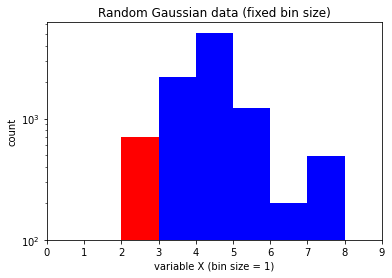

In [24]:
import numpy as np
from matplotlib import pyplot as plt

data=[PCCSelf,PCCSameCluster,PCCOtherCluster]
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(0, 100, 1) # fixed bin size

plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 1)')
plt.ylabel('count')

plt.show()

In [22]:
#the greater the value, the better
print(sum(PCCList))

38310
